## Calculate correlation between bands

In [10]:
%reload_ext autoreload
%autoreload 2
import os
import gc
import re
import sys
import glob
import pickle
import itertools
import numpy as np
import scipy
import scipy as sc
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
try:
    from pyhdf.SD import SD, SDC
except:
    pass
from tensorflow.python.keras.models import Model
from tensorflow.data.experimental import parallel_interleave
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches
from matplotlib.backends.backend_pdf import PdfPages

In [81]:
import seaborn as sns

#### Load patches

In [3]:
def data_extractor_fn(filelist,prefetch=1,read_threads=1, distribute=(1, 0), shape_size=3):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """

        features = {
            "shape": tf.FixedLenFeature([shape_size], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }        
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        #patch = tf.cast(patch, tf.float32)
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    idx = 0
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                if idx == 0:
                    patches = np.expand_dims(patch, axis=0)
                else:
                    patches = np.concatenate(
                        [patches,np.expand_dims(patch, axis=0) ], axis=0)
                idx+=1
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches

In [4]:
tf_datadir='/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle'

In [5]:
filelist = glob.glob(os.path.join(tf_datadir, '*.tfrecord'))

In [103]:
len(filelist) * 41 / 60.00

16.4

In [105]:
8*2000*128*128*6*len(filelist) /1024/1024/1024

35.15625

In [6]:
patches = None
patches =data_extractor_fn(filelist[:2],read_threads=4,shape_size=3)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process


In [7]:
patches.shape

(4000, 128, 128, 6)

### Band corerlation

In [15]:
def calc_corr(patches):
    ## compute pearson correlation
    bands = [ str(i) for i in [6,7,20,28,29,31]]
    index = np.arange(len(bands))
    results = dict()
    for (ix,iy) in  itertools.combinations(index,2):
        x = patches[:,:,:,ix]
        y = patches[:,:,:,iy]
        corr, p_val = pearsonr(x.ravel(), y.ravel())

        # results
        iband = bands[ix]
        jband = bands[iy]
        results[f'band-{iband}-{jband}'] = {'corr':corr, 'p_val':p_val}
    return results

In [16]:
results = calc_corr(patches)

In [17]:
results

{'band-6-7': {'corr': 0.9814473948212111, 'p_val': 0.0},
 'band-6-20': {'corr': 0.8134023730997031, 'p_val': 0.0},
 'band-6-28': {'corr': 0.5138355547743066, 'p_val': 0.0},
 'band-6-29': {'corr': 0.4591057930398692, 'p_val': 0.0},
 'band-6-31': {'corr': 0.4814842257129496, 'p_val': 0.0},
 'band-7-20': {'corr': 0.8777858486264039, 'p_val': 0.0},
 'band-7-28': {'corr': 0.5074225068358733, 'p_val': 0.0},
 'band-7-29': {'corr': 0.4538343821387192, 'p_val': 0.0},
 'band-7-31': {'corr': 0.47515625650457094, 'p_val': 0.0},
 'band-20-28': {'corr': 0.6916524943384856, 'p_val': 0.0},
 'band-20-29': {'corr': 0.6808657167876959, 'p_val': 0.0},
 'band-20-31': {'corr': 0.6841684665422068, 'p_val': 0.0},
 'band-28-29': {'corr': 0.9776220449120818, 'p_val': 0.0},
 'band-28-31': {'corr': 0.9853108935247994, 'p_val': 0.0},
 'band-29-31': {'corr': 0.9969868222211934, 'p_val': 0.0}}

In [18]:
### Save
df = pd.DataFrame.from_dict(results, orient='index')
df.to_csv('./band_corr-notebook.csv')

### Make confusion matrix

In [77]:
bands = [6,7,20,28,29,31]

In [78]:
band2index = {6:0,7:1,20:2,28:3,29:4,31:5}

In [47]:
n = 6
corr_matrix = np.eye(n).astype(np.float64)

for key, val in results.items():
    nums = re.findall('[0-9]+',key)
    ii= band2index[int(nums[0])]
    jj= band2index[int(nums[1])]
    corr_matrix[ii,jj] = val['corr']

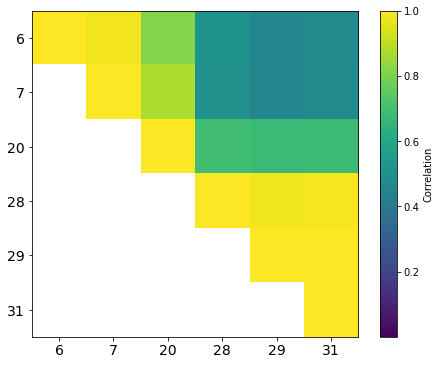

In [118]:
fs = 14
fig=plt.figure(figsize=(8,6))
x = np.arange(len(bands))
im1= plt.imshow(corr_matrix, vmin=1.0e-10, vmax=1, cmap='viridis')
im1.cmap.set_under('w')
cbar = plt.colorbar()
#cbar.ax.tick_params(labelsize=8) 
cbar.set_label('Correlation')
#cbar.ax.set_label('Correlation', labelsize-fs)
plt.ylim(-0.5,5.5)
plt.xticks(x,[str(i) for i in bands], fontsize=fs)
plt.yticks(x,[str(i) for i in bands], fontsize=fs)
plt.gca().invert_yaxis()
#plt.show()
pdf = PdfPages("./corr-bands.pdf")
plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
pdf.close()
pdf = None